<a href="https://colab.research.google.com/github/yeesem/Deep_Learning/blob/main/Siamese_Network_Fashion_Mnist_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Flatten,Dense, Dropout,Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image,ImageFont,ImageDraw
import random

# Prepare Dataset

In [5]:
def create_pairs(x,digit_indices):
  pairs = []
  labels = []
  n = min([len(digit_indices[d]) for d in range(10)]) - 1

  for d in range(10):
    for i in range(n):
      z1,z2 = digit_indices[d][i],digit_indices[d][i+1]
      pairs += [[x[z1],x[z2]]]
      # generate a random integer between 1 and 9
      inc = random.randrange(1,10)
      dn = (d + inc) % 10
      z1,z2 = digit_indices[d][i],digit_indices[dn][i]
      pairs += [[x[z1],x[z2]]]
      labels += [1,0]

  return np.array(pairs),np.array(labels)

def create_pairs_on_set(images, labels):

    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')

    return pairs, y


def show_image(image):
  plt.figure()
  plt.imshow(image)
  plt.colorbar()
  plt.grid(False)
  plt.show()

In [6]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

4422102/4422102 [==============================] - 1s 0us/step


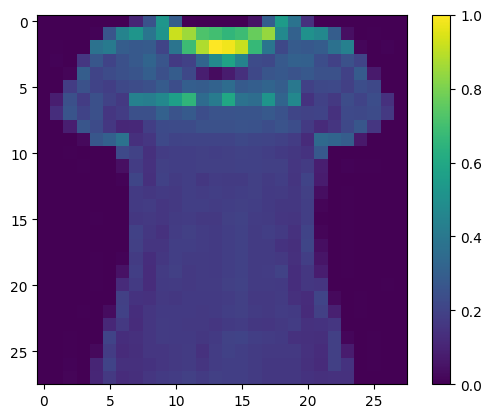

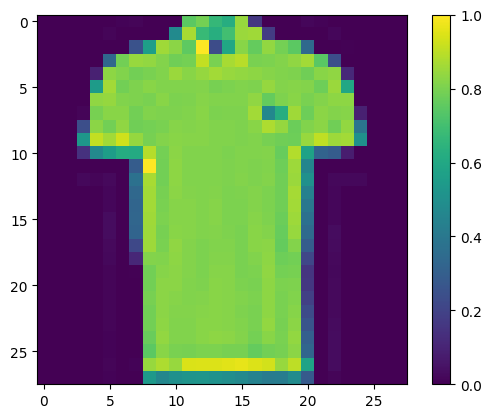

1.0


In [7]:
# Array index
this_pair = 8

# Show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# Print the label for this pair
print(ts_y[this_pair])

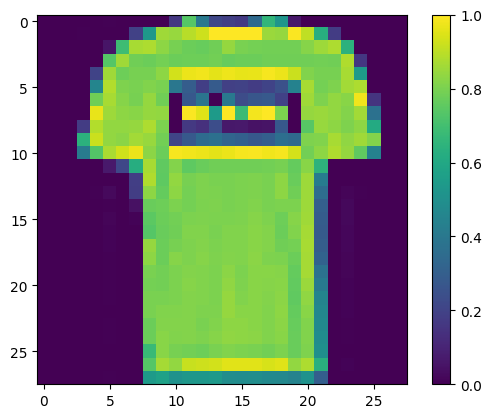

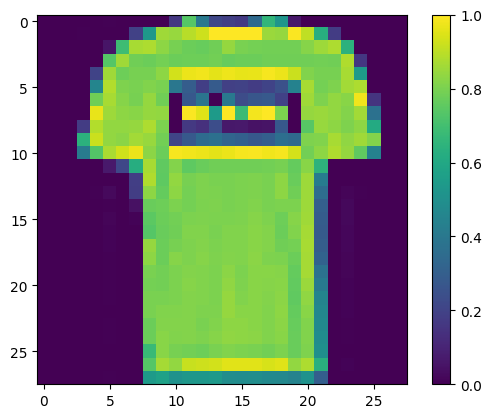

1.0



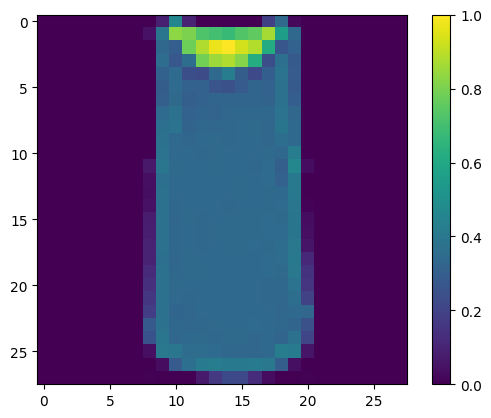

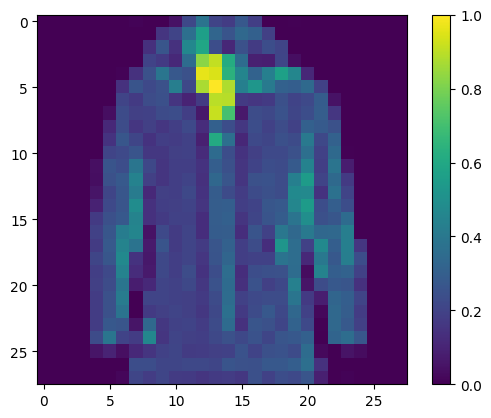

0.0


In [8]:
# Print other pairs
show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])
print(ts_y[0])

print()

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])
print(ts_y[1])

# Build the Model

In [11]:
def initialize_base_network():
  input = Input(shape = (28,28),
                name = 'base_input')
  X = Flatten(name = 'flatten_input')(input)
  X = Dense(128,activation = 'relu',name = 'first_base_dense')(X)
  X = Dropout(0.1,name = 'first_dropout')(X)
  X = Dense(128,activation = 'relu',name = 'second_base_dense')(X)
  X = Dropout(0.1,name = 'second_dropout')(X)
  X = Dense(128,activation = 'relu',name = 'third_base_dense')(X)

  return Model(inputs = input,outputs = X)

def euclidean_distance(vects):
  x,y = vects
  sum_square = K.sum(K.square(x - y),axis = 1,keepdims = True)
  return K.sqrt(K.maximum(sum_square,K.epsilon()))

def eucl_dist_output_shape(shapes):
  shape1,shape2 = shapes
  return (shape1[0],1)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_input (InputLayer)     [(None, 28, 28)]          0         
                                                                 
 flatten_input (Flatten)     (None, 784)               0         
                                                                 
 first_base_dense (Dense)    (None, 128)               100480    
                                                                 
 first_dropout (Dropout)     (None, 128)               0         
                                                                 
 second_base_dense (Dense)   (None, 128)               16512     
                                                                 
 second_dropout (Dropout)    (None, 128)               0         
                                                                 
 third_base_dense (Dense)    (None, 128)               1651

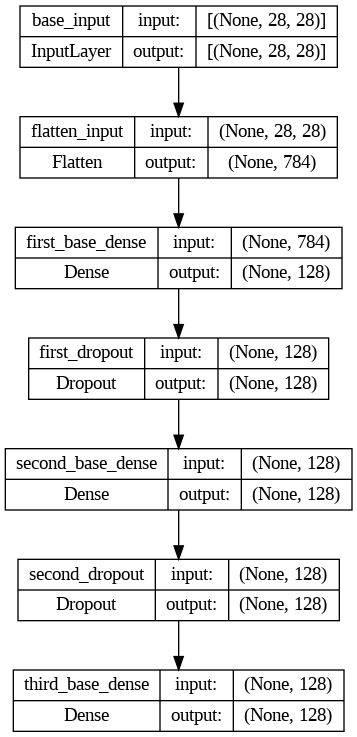

In [19]:
base_network = initialize_base_network()
base_network.summary()
plot_model(base_network, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

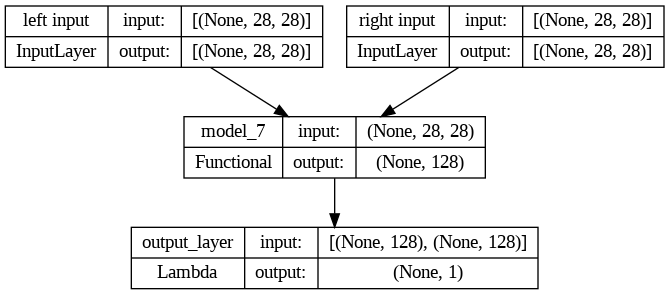

In [24]:
# Create the left input and point to the base network
input_a = Input(shape = (28,28),name = 'left input')
vector_output_a = base_network(input_a)

# Create the right input and point to the base network
input_b = Input(shape = (28,28),name = 'right input')
vector_output_b = base_network(input_b)

# Measure the similarity of the two vector outputs
output = Lambda(euclidean_distance,name = 'output_layer',output_shape = eucl_dist_output_shape)([vector_output_a,vector_output_b])

# Specify the inputs and outputs of the model
model = Model([input_a,input_b],output)

# Plot the model graph
plot_model(model,show_shapes = True,show_layer_names = True)

# Train the model

In [41]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true,y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred,0))
    return (y_true * square_pred + (1 - y_true) * margin_square)

  return contrastive_loss

In [42]:
rms = RMSprop()

model.compile(
    loss = contrastive_loss_with_margin(margin = 1),
    optimizer = rms
)

history = model.fit([tr_pairs[:,0], tr_pairs[:,1]],
                    tr_y,
                    epochs=20,
                    batch_size=128,
                    validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 12s 12ms/step - loss: 0.0828 - val_loss: 0.0796
Epoch 2/20
938/938 [==============================] - 12s 13ms/step - loss: 0.0736 - val_loss: 0.0718
Epoch 3/20
938/938 [==============================] - 10s 10ms/step - loss: 0.0676 - val_loss: 0.0681
Epoch 4/20
938/938 [==============================] - 15s 16ms/step - loss: 0.0643 - val_loss: 0.0675
Epoch 5/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0621 - val_loss: 0.0633
Epoch 6/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0603 - val_loss: 0.0672
Epoch 7/20
938/938 [==============================] - 15s 16ms/step - loss: 0.0587 - val_loss: 0.0646
Epoch 8/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0575 - val_loss: 0.0623
Epoch 9/20
938/938 [==============================] - 11s 11ms/step - loss: 0.0562 - val_loss: 0.0624
Epoch 10/20
938/938 [==============================] - 10s 11ms/step - loss: 0.055

# Model Evaluation

In [43]:
def compute_accuracy(y_true,y_pred):
  pred = y_pred.ravel() < 0.5
  return np.mean(pred == y_true)

In [44]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0],tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y,y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0],ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y,y_pred_test)

print("Loss : ",loss)
print("Training accuracy : ",train_accuracy)
print("Testing  accuracy : ",test_accuracy)

625/625 [==============================] - 2s 3ms/step
Loss :  0.060254376381635666
Training accuracy :  0.9446407734622437
Testing  accuracy :  0.9157657657657657


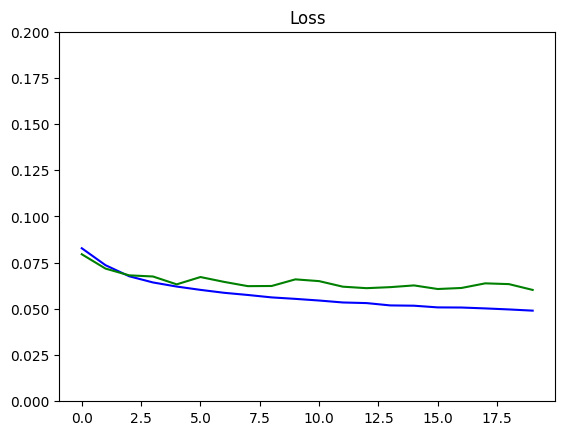

In [45]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [46]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)



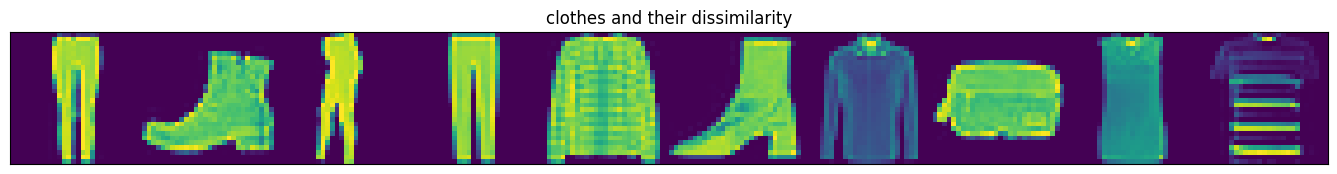

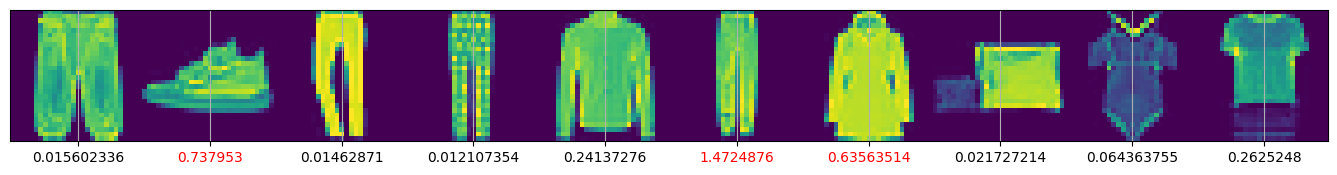

In [47]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)